### Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

There are two architectures for implementing Word2Vec:
> CBOW (Continuous Bag-Of-Words)

> Skip-gram

**In general Skip-gram works better than CBOW and we will use that in this notebook**

### Download and load the data

In [2]:
zip_file_url = r"https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip"

In [3]:
import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content/sample_data")

In [4]:
with open('/content/sample_data/text8') as f:
    text = f.read()
# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


### Preprocessing helpers

In [5]:
import re
from collections import Counter

def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words


def create_lookup_tables(words):
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

### Tokenizing the text

In [6]:
words = preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [7]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
print(int_words[0:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


### Subsampling int_words

- Subsampling technique refers to removing words that have high frequency like as, of, the, etc.

- Probability of discarding the word
$P(w_i) = 1 - \sqrt{\frac{threshold}{frequency(w_i)}}$

- Frequency of word w_i is defined as $\frac{count(w_i)}{total\ count}$

In [8]:
import numpy as np
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(word_counts)
p_drop = {word:1 - np.sqrt(threshold * total_count/cnt) for word, cnt in word_counts.items()}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[31, 25636, 7239, 15068, 1123, 6598, 53723, 27349, 53724, 40561, 4044, 11064, 200, 215, 12061, 50, 8716, 14497, 1555, 2654, 1258, 10638, 18741, 912, 10464, 9216, 9033, 42433, 7088, 10270]


In [9]:
print(f"Total words in training_words: {len(train_words)}")
print(f"Unique words in training_words: {len(set(train_words))}")

Total words in training_words: 397974
Unique words in training_words: 61538


### Making Batches

In [10]:
def get_target(words, idx, max_window_size = 5):
    window_size = np.random.randint(low = 1, high = max_window_size + 1)
    start = idx - window_size if idx - window_size > 0 else 0
    finish = idx + window_size
    target_words = words[start:idx]
    target_words = np.append(target_words, words[idx + 1: finish + 1])
    return list(target_words)

In [11]:
test_ints = np.array([i for i in range(10)])
print(f"test_ints : {test_ints}")
print(f"target words for idx = 0 and window_max_size = 6 : {get_target(test_ints, 0, 6)}")

test_ints : [0 1 2 3 4 5 6 7 8 9]
target words for idx = 0 and window_max_size = 6 : [1, 2, 3]


### Generating Batches

In [12]:
def get_batches(words, batch_size, window_size = 5):
    n_batches = len(words)//batch_size
    for batch in range(n_batches):
        x = []
        y = []
        cur_batch = words[batch * batch_size:(batch + 1) * batch_size]
        for word_of_interest in range(batch_size):
            batch_x = cur_batch[word_of_interest]
            batch_y = get_target(words = cur_batch, idx = word_of_interest, max_window_size = window_size)
            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y))
        yield x, y

In [13]:
test_ints = np.arange(20)
x, y = next(get_batches(test_ints, 4, 5))
print(f"x: {x}")
print(f"y: {y}")

x: [0, 0, 0, 1, 1, 1, 2, 2, 3]
y: [1, 2, 3, 0, 2, 3, 1, 3, 2]


### Cosine Similarity between word vectors

In [14]:
import torch
def cosine_similarity(embedding, valid_size = 16, valid_window = 100, device = 'cpu'):
    embed_vectors = embedding.weight
    magnitudes = embed_vectors.pow(2).sum(dim = 1).sqrt().unsqueeze(0)

    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t()) / magnitudes
    return valid_examples, similarities


### Skip Gram Model

In [15]:
from torch import nn
import torch.optim as optim

In [16]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super(SkipGram, self).__init__()
        self.embed = nn.Embedding(num_embeddings=n_vocab, embedding_dim=n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim = 1)
    def forward(self, x):
        x = self.embed(x)
        log_ps = self.log_softmax(self.output(x))
        return log_ps

### Training

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_dim = 300

# As we don't know which words from vocab got filtered, we use whole dict for input and output
model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

print_every = 500
steps = 0
epochs = 5

for epoch in range(epochs):
    for inputs, targets in get_batches(train_words, batch_size=512, window_size=5):
        steps += 1
        inputs, targets = torch.LongTensor(inputs).to(device), torch.LongTensor(targets).to(device)

        log_ps = model(inputs)
        optimizer.zero_grad()
        loss = criterion(log_ps, targets)
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:
            print(f"Epoch : {epoch} | Step : {steps}")
            valid_ex, valid_sim = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_sim.topk(6)
            valid_ex, closest_idxs = valid_ex.to("cpu"), closest_idxs.to("cpu")
            for ii, valid_idx in enumerate(valid_ex):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii][1:]]
                print(f"{int_to_vocab[valid_idx.item()]} -> {', '.join(closest_words)}")

Epoch : 0 | Step : 500
four -> illustrations, cip, encyclopedias, monomorphism, agar
are -> korps, prerogative, mere, ccc, orexin
there -> fretboard, batavian, decatur, sheldrake, aleichem
for -> tetrahydrocannabinol, sanctioning, potentiation, lactantius, interchanges
has -> parkland, pseudopod, chogm, typos, benjamins
when -> thriving, drumming, duvall, ergonomics, professional
b -> breasts, interfering, defendants, changsha, prds
no -> barratry, ape, lifetime, totaled, taxon
alternative -> walvis, epoxy, frisia, locales, confiscation
ice -> boa, poorly, timepiece, plastids, hangings
behind -> quantized, gaba, consisted, grains, flagg
dr -> northwestern, via, norm, synchronized, barfield
square -> entries, altogether, kq, regionally, gumbo
something -> atrahasis, beals, descends, ultrasonic, vme
egypt -> belial, qasim, abounding, athelstan, mcclintock
running -> gynecologists, duty, tino, selfish, symbolical
Epoch : 1 | Step : 1000
american -> whittier, subtraction, panoramas, barbar

### Visualizing the word vectors

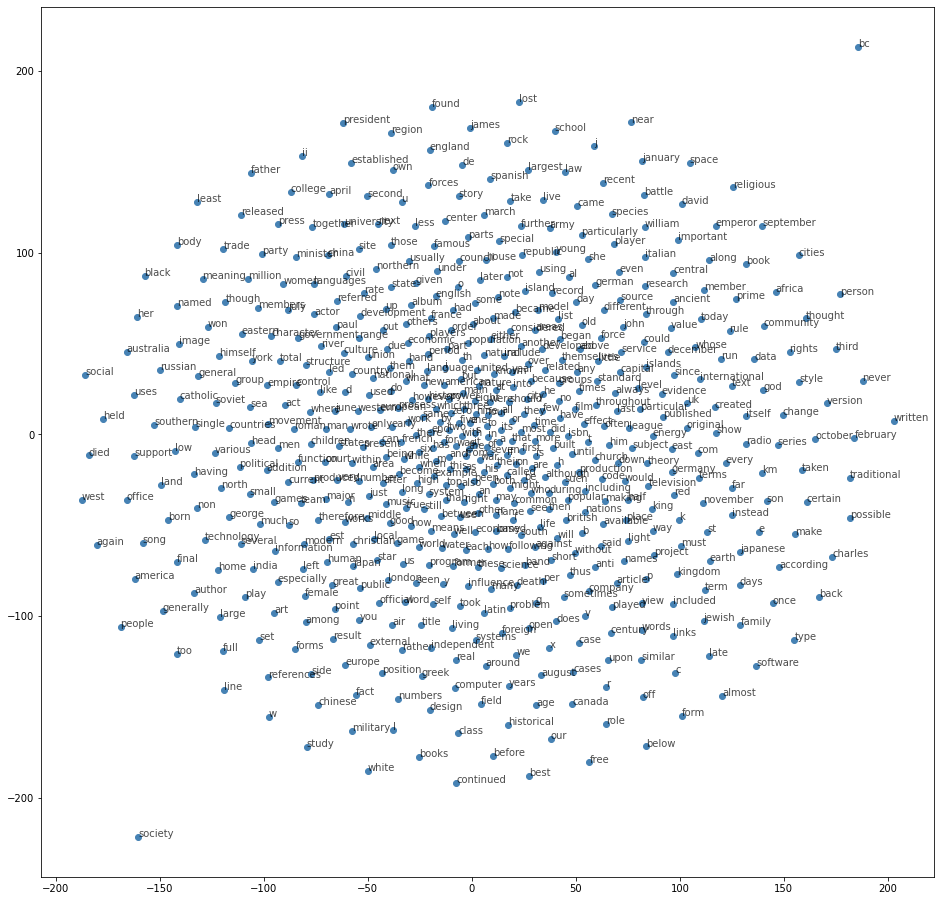

In [25]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
embeddings = model.embed.weight.to("cpu").data.numpy()
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize = (16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx,:], color = "steelblue")
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha = 0.7)